## 1. Defining the GAIN for imputation

In [ ]:
# Packages
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm_notebook as tqdm

import torch.nn.functional as F
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from numpy import linalg as LA

import pandas as pd
from sklearn import preprocessing

import seaborn as sns
sns.set()

use_gpu = False # set it to True to use GPU and False to use CPU
if use_gpu:
    torch.cuda.set_device(0)


 # %% Initialize System Parameters
def init_params(mb_size=128, p_miss=0.2, p_hint=0.9, alpha=10, train_rate=0.8, learning_rate=0.001, epochs=10000):
    # Mini batch size
    mb_size = mb_size
    # Missing rate
    p_miss = p_miss
    # Hint rate
    p_hint = p_hint
    # Loss Hyperparameters
    alpha = alpha
    # Train Rate
    train_rate = train_rate
    # Learning Rate
    learning_rate = learning_rate
    # Epochs
    epochs = epochs

    return mb_size, p_miss, p_hint, alpha, train_rate, learning_rate, epochs

mb_size, p_miss, p_hint, alpha, train_rate, learning_rate, epochs = init_params()

# Discriminator
class NetD(torch.nn.Module):
    def __init__(self, Dim, H_Dim1, H_Dim2):
        super(NetD, self).__init__()

        self.fc0 = torch.nn.Linear(Dim * 1, H_Dim1) # without Hint
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1) # with Hint

        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc3 = torch.nn.Linear(H_Dim2, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc0, self.fc1, self.fc2, self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, h, hint):
        if hint == False:
            inp = x # Data without Hint
            out = self.relu(self.fc0(inp))
        else:
            inp = torch.cat((x, h), dim=1)  # Hint + Data Concatenate
            out = self.relu(self.fc1(inp))

        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out)) # [0,1] Probability Output
        return out

# Generator
class NetG(torch.nn.Module):
    def __init__(self, Dim, H_Dim1, H_Dim2):
        super(NetG, self).__init__()
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1)
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc3 = torch.nn.Linear(H_Dim2, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, m):
        inp = torch.cat((x, m), dim=1)
        out = self.relu(self.fc1(inp))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out)) # [0,1] Probability Output
        return out

# Hint Vector Generation
def sample_M(m, n, p):                         # e.g. m=mb_size , n=Dim, p=1-p_hint =0.1
    A = np.random.uniform(0., 1., size=[m, n]) # size of mb_size X Dim -> values between 0 to 1
    B = A > p                                  # if A value bigger than 0.1 then True and C=1 else False and C=0
    C = 1. * B
    return C                                   # C is shape mb_size X Dim


# Random sample generator for Z
def sample_Z(m, n):
    return np.random.uniform(0., 0.01, size = [m, n])


# Mini-batch generation
def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx


def discriminator_loss(netG, netD, M, X, H, hint):
    # Generator
    G_sample = netG(X, M)
    # Combine with original data
    Hat_New_X = X * M + G_sample * (1-M)
    # Discriminator
    D_prob = netD(Hat_New_X, H, hint)
    # Loss
    D_loss = -torch.mean(M * torch.log(D_prob + 1e-8) + (1-M) * torch.log(1. - D_prob + 1e-8))
    return D_loss

def generator_loss(netG, netD, X, M, New_X, H, Lg, Lm, hint, alpha=alpha):
    # %% Structure
    # Generator
    G_sample = netG(New_X, M)
    # Combine with original data
    Hat_New_X = New_X * M + G_sample * (1-M)
    # Discriminator
    D_prob = netD(Hat_New_X, H, hint)

    # Loss
    G_loss1 = -torch.mean((1-M) * torch.log(D_prob + 1e-8))
    # MSE loss finds the difference between New_X and Generators Sample only on the real values
    # Because i want the real values to be as close as they can be to the New_X. I care only for the imputed values
    MSE_train_loss = torch.mean((M * New_X - M * G_sample)**2) / torch.mean(M)

    # G_loss = G_loss1 + alpha * MSE_train_loss
    if Lm == False:
        G_loss = G_loss1
    elif Lg == False:
        G_loss = alpha * MSE_train_loss
    elif (Lm == True) and (Lg == True):
        G_loss = G_loss1 + alpha * MSE_train_loss

    # MSE Performance metric
    # The difference between real data , X and the Imputed Data
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return G_loss, MSE_train_loss, MSE_test_loss

def test_loss(netG, netD, X, M, New_X):
    # %% Structure
    # Generator
    G_sample = netG(New_X, M)

    # MSE Performance metric
    # The difference between real data , X and the Imputed Data
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return MSE_test_loss, G_sample

def initializations(dataset_file, size=False, lnth=0, impute=False):
    # Data generation
    Data = np.loadtxt(dataset_file, delimiter=",", skiprows=1)
    # Shuffle Data
    np.random.seed(1234)
    np.random.shuffle(Data)

    if size==True:
        Data = Data[:lnth] # for data set size vs rmse plot

    if impute==True:
        Data_y = Data[:,Data.shape[1]-1]
        Data = Data[:,:Data.shape[1]-1]

    # Parameters
    No = len(Data)
    Dim = len(Data[0,:])

    # Hidden state dimensions
    H_Dim1 = Dim
    H_Dim2 = Dim

    # Normalization (0 to 1)
    # z = (x-min) / (X_max + ε)
    # ε is used to avoid division by zero
    Min_Val = np.zeros(Dim)
    Max_Val = np.zeros(Dim)

    for i in range(Dim):
        Min_Val[i] = np.min(Data[:,i])
        Data[:,i] = Data[:,i] - np.min(Data[:,i])
        Max_Val[i] = np.max(Data[:,i])
        Data[:,i] = Data[:,i] / (np.max(Data[:,i]) + 1e-6)

# %% Missing introducing
    p_miss_vec = p_miss * np.ones((Dim,1)) # p_miss ... Dim x 1 size, Dim is number of columns of dataset

    Missing = np.zeros((No,Dim))           # zero ... Size of dataset No, Dim , No is the rows
    # Mask Vector Generation
    for i in range(Dim):
        A = np.random.uniform(0., 1., size = [len(Data),]) # A is size No x 1
        B = A > p_miss_vec[i]       # B is size No x 1, If a value is False, it is a missing data point
        Missing[:,i] = 1.*B         # No x Dim, 1 * False = 0 and 1 * True = 1

    # %% Train Test Division
    idx = np.random.permutation(No) # number of No values. permutation of numbers from 0 - No
    Train_No = int(No * train_rate) # No.of Rows * train_rate
    Test_No = No - Train_No         # 1 - Train_No

    if impute==False:
        return Data, No, Dim, H_Dim1, H_Dim2, Min_Val, Max_Val, p_miss_vec, Missing, idx, Train_No, Test_No
    else:
        return Data, Data_y, No, Dim, H_Dim1, H_Dim2, Min_Val, Max_Val, p_miss_vec, Missing, idx, Train_No, Test_No

def trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, cv=True, Lg=True, Lm=True, hint=True,
              alpha=alpha, epochs=epochs, printLoss=False):
    # %% Training
    # %% Start Iterations
    for it in tqdm(range(epochs)):
        # %% Inputs
        if cv == False:
            mb_idx = sample_idx(Train_No, mb_size)    # choose indexes
            X_mb = trainX[mb_idx,:]

            Z_mb = sample_Z(mb_size, Dim)             # uniform 0 to 0.01
            M_mb = trainM[mb_idx, :]                  # mini batch for Missing, 1 and 0 matrix
            H_mb1 = sample_M(mb_size, Dim, 1-p_hint)  # random 0 or 1 with 1 if prob > 0.1
            H_mb = M_mb * H_mb1 # Hint vector final -> 0 on all Missing values and also to some known
                                # because of a small probability that H_mb1 having 0 values,
                                # but most known data points are 1

            New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce

        else:
            mb_idx = sample_idx(len(trainX), mb_size)
            X_mb = trainX[mb_idx, :]

            Z_mb = sample_Z(mb_size, Dim)
            M_mb = trainM[mb_idx, :]
            H_mb1 = sample_M(mb_size, Dim, 1-p_hint)
            H_mb = M_mb * H_mb1

            New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb

        if use_gpu is True:
            X_mb = torch.tensor(X_mb, device='cuda').float()
            M_mb = torch.tensor(M_mb, device='cuda').float()
            H_mb = torch.tensor(H_mb, device='cuda').float()
            New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
        else:
            X_mb = torch.tensor(X_mb).float()
            M_mb = torch.tensor(M_mb).float()
            H_mb = torch.tensor(H_mb).float()
            New_X_mb = torch.tensor(New_X_mb).float()

# Train D
        optimD.zero_grad()
        D_loss = discriminator_loss(netG, netD, M=M_mb, X=New_X_mb, H=H_mb, hint=hint)
        D_loss.backward()
        optimD.step()

        # Train G
        optimG.zero_grad()
        G_loss, G_mse_loss, G_mse_test = generator_loss(netG, netD, X=X_mb, M=M_mb, New_X=New_X_mb, H=H_mb,
                                                        Lg=Lg, Lm=Lm, hint=hint, alpha=alpha)
        G_loss.backward()
        optimG.step()

        # %% Intermediate Losses
        if printLoss==True:
            if it % 100 == 0:
                print('Iter: {}'.format(it),end='\t')
                print('Train_loss: {:.4}'.format(G_mse_loss),end='\t')
                print('Test_loss: {:.4}'.format(G_mse_test),end='\t')
                print('D_loss: {:.4}'.format(D_loss))

def testGAIN(netG, netD, Dim, testM, testX, cv=True, impute=False):
    if cv == False:
        Z_mb = sample_Z(Test_No, Dim)
    else:
        Z_mb = sample_Z(len(testM), Dim)

    M_mb = testM # all test samples together
    X_mb = testX

    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce

    # make the tensors
    if use_gpu is True:
        X_mb = torch.tensor(X_mb, device='cuda').float()
        M_mb = torch.tensor(M_mb, device='cuda').float()
        New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
    else:
        X_mb = torch.tensor(X_mb).float()
        M_mb = torch.tensor(M_mb).float()
        New_X_mb = torch.tensor(New_X_mb).float()

    MSE_final, Sample = test_loss(netG, netD, X=X_mb, M=M_mb, New_X=New_X_mb)

    """print('Final Test RMSE: ' + str(np.sqrt(MSE_final.item())))
    print()"""

    if impute==False:
        return np.sqrt(MSE_final.item())
    else:
        return Sample


def experiment(dataset_file, Lg=True, Lm=True, hint=True, alpha=alpha, epochs=epochs,
               learning_rate=learning_rate, size=False, lnth=0, impute=False, printLoss=False):
    # %% Initializations
    if impute==False:
        if size==False:
            Data, No, Dim, H_Dim1, H_Dim2, Min_Val, Max_Val, p_miss_vec, Missing, idx, Train_No, Test_No = initializations(dataset_file)
        else:
            Data, No, Dim, H_Dim1, H_Dim2, Min_Val, Max_Val, p_miss_vec, Missing, idx, Train_No, Test_No = initializations(dataset_file, size=size, lnth=lnth)
    else:
        Data, Data_y, No, Dim, H_Dim1, H_Dim2, Min_Val, Max_Val, p_miss_vec, Missing, idx, Train_No, Test_No = initializations(dataset_file, impute=impute)

    # %% Cross Validation
    kf = KFold(n_splits=5)
    experiment_rmse_mean =[]
    experiment_rmse_std=[]
    auroc_mean = []

    for i in range(2): # Number of experiments
        if impute==False:
            rmse_cv_scores=[]
            for train_index, test_index in kf.split(Data):

                # Train / Test Features
                trainX, testX = Data[train_index], Data[test_index]
                # Train / Test Missing Indicators
                trainM, testM = Missing[train_index], Missing[test_index]

                if impute==True:
                    trainY, testY = Data_y[train_index], Data_y[test_index]

                # %% Init Network
                if use_gpu is True:
                    netD = NetD(Dim, H_Dim1, H_Dim2).cuda()
                    netG = NetG(Dim, H_Dim1, H_Dim2).cuda()
                else:
                    netD = NetD(Dim, H_Dim1, H_Dim2)
                    netG = NetG(Dim, H_Dim1, H_Dim2)

                # Optimizers
                optimD = torch.optim.Adam(netD.parameters(), lr=learning_rate) # discriminator optimizer
                optimG = torch.optim.Adam(netG.parameters(), lr=learning_rate) # generator optimizer

                # %% Training
                trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, Lg=Lg, Lm=Lm, hint=hint,
                          alpha=alpha, epochs=epochs, printLoss=printLoss)

                # %% Testing
                if impute==False:
                    rmse_cv_scores.append(testGAIN(netG, netD, Dim, testM, testX))
                else:
                    # Impute train and test and then fit on logistic
                    trainX = testGAIN(netG, netD, Dim, trainX, trainM, impute=impute)
                    testX  = testGAIN(netG, netD, Dim, testX, testM, impute=impute)

                    # Train a logistic Regression
                    clf = LogisticRegression(random_state=0,solver='lbfgs',
                                             max_iter=2000).fit(trainX.detach().numpy(),trainY)
                    preds = clf.predict(testX.detach().numpy())

                    # print("roc_auc_score: {}".format(roc_auc_score(testY, preds)))
                    fpr, tpr, thresholds = roc_curve(testY, preds)
                    auroc_scores.append(auc(fpr, tpr))

            # %% Calculate avg_RMSE on test
            mean = sum(rmse_cv_scores) / len(rmse_cv_scores)
            print("Average RMSE score: {}".format(mean))

            # %% Calculate the std on test
            variance = sum((rmse - mean) ** 2 for rmse in rmse_cv_scores) / len(rmse_cv_scores)
            std = np.sqrt(variance)
            print("Standard Deviation of RMSE score: {}".format(std))

            experiment_rmse_mean.append(mean)
            experiment_rmse_std.append(std)
        else:
            auroc_scores=[]
            for train_index, test_index in kf.split(Data, Data_y):
                trainX, testX = Data[train_index], Data[test_index]
                trainM, testM = Missing[train_index], Missing[test_index]
                trainY, testY = Data_y[train_index] , Data_y[test_index]

                if use_gpu is True:
                    netD = NetD(Dim, H_Dim1, H_Dim2).cuda()
                    netG = NetG(Dim, H_Dim1, H_Dim2).cuda()
                else:
                    netD = NetD(Dim, H_Dim1, H_Dim2)
                    netG = NetG(Dim, H_Dim1, H_Dim2)

                optimD = torch.optim.Adam(netD.parameters(), lr=learning_rate) # discriminator optimizer
                optimG = torch.optim.Adam(netG.parameters(), lr=learning_rate) # generator optimizer

                trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, Lg=Lg, Lm=Lm, hint=hint,
                          alpha=alpha, epochs=epochs, printLoss=printLoss)

                # Impute train and test and then fit on logistic
                trainX = testGAIN(netG, netD, Dim, trainX, trainM, impute=impute)
                testX  = testGAIN(netG, netD, Dim, testX, testM, impute=impute)

                # Train a logistic Regression
                clf = LogisticRegression(random_state=0,solver='liblinear',
                                         max_iter=2000).fit(trainX.detach().numpy(),trainY)
                preds = clf.predict(testX.detach().numpy())
                #################
                param_grid = {
                    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                    'penalty': ['l1', 'l2'],
                    'class_weight': [None, 'balanced'],
                    'max_iter': [1000, 2000]
                                            }

                clf = GridSearchCV(
                    estimator=LogisticRegression(solver='liblinear', random_state=0),
                    param_grid=param_grid,
                    scoring='roc_auc',  # or 'accuracy', depending on the objective
                    cv=2,
                    n_jobs=-1
                                            )
                clf.fit(trainX.detach().numpy(), trainY)
                preds = clf.predict(testX.detach().numpy())
                ####################
                # print("roc_auc_score: {}".format(roc_auc_score(testY, preds)))
                fpr, tpr, thresholds = roc_curve(testY, preds)
                auroc_scores.append(auc(fpr, tpr))

            auroc_mean.append(np.mean(auroc_scores))

    if impute==False:
        total_avg = sum(experiment_rmse_mean) / len(experiment_rmse_mean)
        total_std = np.sqrt(sum((rmse - total_avg )**2 for rmse in experiment_rmse_mean)/len(experiment_rmse_mean))
        print("Total average: {}".format(total_avg))
        print("Total std: {}".format(total_std))
        return total_avg, total_std
    else:
        return auroc_mean


# # Grid search with 5-fold CV for GAIN hyperparameters
# from itertools import product

# def grid_search_gain_cv(dataset_file, alpha_list, learning_rate_list, epoch_list):
#     results = []

#     for alpha, lr, ep in product(alpha_list, learning_rate_list, epoch_list):
#         print(f"Testing alpha={alpha}, lr={lr}, epochs={ep}")

#         avg_rmse, std_rmse = experiment(
#             dataset_file=dataset_file,
#             Lg=True,
#             Lm=True,
#             hint=True,
#             alpha=alpha,
#             epochs=ep,
#             learning_rate=lr,
#             impute=False,  # Imputation-only evaluation
#             printLoss=False
#         )

#         results.append({
#             'alpha': alpha,
#             'learning_rate': lr,
#             'epochs': ep,
#             'avg_rmse': avg_rmse,
#             'std_rmse': std_rmse
#         })

#     # 결과 DataFrame으로 반환
#     return pd.DataFrame(results).sort_values(by='avg_rmse')


## 2. Reading Default of Credit Card Dataset

In [ ]:
import pandas as pd
#dc dataset
train = pd.read_csv('credit.csv')

In [ ]:
train.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [ ]:
defaulters = train.copy()
print(defaulters.shape)

(30000, 25)


In [ ]:
defaulters.rename(columns={'default payment next month':'def_pay'}, inplace=True)
defaulters.rename(columns={'PAY_0':'PAY_1'}, inplace=True)

In [ ]:
defaulters.isna().sum()    # check for missing values

,0
ID,0
LIMIT_BAL,0
SEX,0
EDUCATION,0
MARRIAGE,0
AGE,0
PAY_1,0
PAY_2,0
PAY_3,0
PAY_4,0


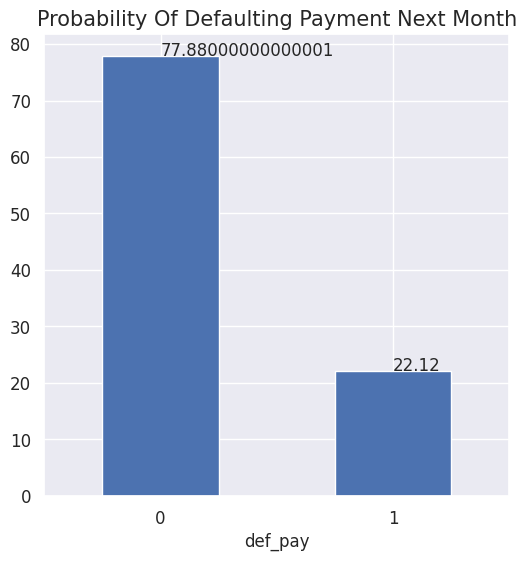

In [ ]:

def_cnt = (defaulters.def_pay.value_counts(normalize=True)*100)
def_cnt.plot.bar(figsize=(6,6))
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.title("Probability Of Defaulting Payment Next Month", fontsize=15)
for x,y in zip([0,1],def_cnt):
    plt.text(x,y,y,fontsize=12)
plt.show()

In [ ]:
df =defaulters.drop(columns=['def_pay'], axis=1)
df = defaulters.drop(columns=['ID'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

## 3. Normalizing the dataset

In [ ]:
df_X = df.drop(['def_pay'], axis=1)
df_y = df.def_pay

X_in = df_X.values
y_in = df_y.values

In [ ]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC, SVC
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
#1. Normalise data

scaler = Normalizer().fit(X_in)
normalisedX = scaler.transform(X_in)
#각 열의 naming 이 되어야 함
#normalisedX 는 뒤에 header 넣는다
new_labels = df_X.columns

In [ ]:
df5 = pd.DataFrame(normalisedX)
df5.columns = new_labels
df5

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.969135,0.000097,0.000097,0.000048,0.001163,0.000097,0.000097,-0.000048,-0.000048,-0.000097,...,0.033387,0.000000,0.000000,0.000000,0.000000,0.033387,0.000000,0.000000,0.000000,0.000000
1,0.998005,0.000017,0.000017,0.000017,0.000216,-0.000008,0.000017,0.000000,0.000000,0.000000,...,0.022305,0.027212,0.028734,0.027121,0.000000,0.008317,0.008317,0.008317,0.000000,0.016633
2,0.898265,0.000020,0.000020,0.000020,0.000339,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.135329,0.143034,0.149192,0.155190,0.015151,0.014971,0.009981,0.009981,0.009981,0.049904
3,0.456620,0.000018,0.000018,0.000009,0.000338,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.450145,0.258575,0.264465,0.269835,0.018265,0.018438,0.010959,0.010046,0.009763,0.009132
4,0.615783,0.000012,0.000025,0.000012,0.000702,-0.000012,0.000000,-0.000012,0.000000,0.000000,...,0.441331,0.257890,0.235795,0.235611,0.024631,0.451750,0.123157,0.110841,0.008485,0.008362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.527102,0.000002,0.000007,0.000002,0.000093,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.499225,0.210850,0.074841,0.038287,0.020365,0.047918,0.011987,0.007300,0.011980,0.002396
29996,0.995086,0.000007,0.000020,0.000013,0.000285,-0.000007,-0.000007,-0.000007,-0.000007,0.000000,...,0.023232,0.059566,0.034430,0.000000,0.012186,0.023391,0.059692,0.000856,0.000000,0.000000
29997,0.579389,0.000019,0.000039,0.000039,0.000715,0.000077,0.000058,0.000039,-0.000019,0.000000,...,0.053265,0.403216,0.397499,0.373841,0.000000,0.000000,0.424885,0.081114,0.038626,0.059870
29998,0.434543,0.000005,0.000016,0.000005,0.000223,0.000005,-0.000005,0.000000,0.000000,0.000000,...,0.414467,0.286657,0.064394,0.265853,0.466590,0.018517,0.006399,0.010462,0.287689,0.009799


## 4 Denoising dataset by randomize Singular Value Decomposition (rSVD)

In [ ]:
# Define randomised SVD function

def rSVD(M, r, q, p):
  ny = M.shape[1]
  P = np.random.randn(ny, r+p)
  Z = M @ P
  for k in range(q):
      Z = M @ (M.T @ Z)

  Q, R = np.linalg.qr(Z, mode='reduced')

  Y = Q.T @ M
  UY, S, VT = np.linalg.svd(Y, full_matrices=0)
  U = Q @ UY

  return U, S, VT

In [ ]:
U, S, VT = np.linalg.svd(normalisedX, full_matrices=0)

r = 22
q = 0
p = 1

rU, rS, rVT = rSVD(normalisedX, r, q, p)
# r=singular values number q=power iteration p=oversampling in the columns
# feature 개수 24 excluding target, max(r) = 24

In [ ]:
#Reconstruction

XSVD = U[:, :(r+1)] @ np.diag(S[:(r+1)]) @ VT[:(r+1), :]
errSVD = np.linalg.norm(normalisedX-XSVD, ord=2) / np.linalg.norm(normalisedX, ord=2)

XrSVD = rU[:, :(r+1)] @ np.diag(rS[:(r+1)]) @ rVT[:(r+1), :]
errSVD = np.linalg.norm(normalisedX-XrSVD, ord=2) / np.linalg.norm(normalisedX, ord=2)

In [ ]:
Xrdsvd = pd.DataFrame(XrSVD)
Xrdsvd.columns = new_labels
Xrdsvd

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.969135,0.000097,0.000097,0.000048,0.001163,9.691351e-05,9.691351e-05,-4.845676e-05,-4.845676e-05,-9.691351e-05,...,0.033387,4.877006e-15,4.182660e-14,8.979892e-16,7.194977e-15,3.338670e-02,2.802896e-14,3.999229e-14,1.339861e-14,2.114970e-14
1,0.998005,0.000017,0.000017,0.000017,0.000216,-8.316705e-06,1.663341e-05,2.949369e-15,6.501086e-15,1.701146e-15,...,0.022305,2.721226e-02,2.873422e-02,2.712078e-02,-2.964856e-15,8.316705e-03,8.316705e-03,8.316705e-03,4.578923e-15,1.663341e-02
2,0.898265,0.000020,0.000020,0.000020,0.000339,-5.833924e-15,-4.221985e-14,6.325619e-15,8.027136e-15,3.635280e-15,...,0.135329,1.430337e-01,1.491918e-01,1.551902e-01,1.515073e-02,1.497108e-02,9.980721e-03,9.980721e-03,9.980721e-03,4.990361e-02
3,0.456620,0.000018,0.000018,0.000009,0.000338,9.182241e-16,1.431962e-15,4.111610e-16,7.483579e-16,6.257445e-16,...,0.450145,2.585749e-01,2.644653e-01,2.698352e-01,1.826481e-02,1.843833e-02,1.095889e-02,1.004565e-02,9.762542e-03,9.132406e-03
4,0.615783,0.000012,0.000025,0.000012,0.000702,-1.231565e-05,2.643143e-15,-1.231565e-05,-6.828509e-16,-8.084229e-17,...,0.441331,2.578898e-01,2.357955e-01,2.356107e-01,2.463130e-02,4.517504e-01,1.231565e-01,1.108409e-01,8.485484e-03,8.362328e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.527102,0.000002,0.000007,0.000002,0.000093,6.002191e-17,1.419887e-16,-2.111553e-17,-1.400022e-16,-6.180158e-17,...,0.499225,2.108503e-01,7.484126e-02,3.828675e-02,2.036530e-02,4.791834e-02,1.198677e-02,7.300359e-03,1.197959e-02,2.395917e-03
29996,0.995086,0.000007,0.000020,0.000013,0.000285,-6.633904e-06,-6.633904e-06,-6.633904e-06,-6.633904e-06,3.825557e-16,...,0.023232,5.956583e-02,3.442996e-02,1.293162e-15,1.218648e-02,2.339115e-02,5.969187e-02,8.557737e-04,7.441942e-16,2.052766e-16
29997,0.579389,0.000019,0.000039,0.000039,0.000715,7.725185e-05,5.793889e-05,3.862593e-05,-1.931296e-05,-1.611534e-16,...,0.053265,4.032161e-01,3.974994e-01,3.738410e-01,1.380272e-16,3.783259e-16,4.248852e-01,8.111445e-02,3.862593e-02,5.987019e-02
29998,0.434543,0.000005,0.000016,0.000005,0.000223,5.431784e-06,-5.431784e-06,-1.439142e-16,-1.855052e-16,-9.799163e-18,...,0.414467,2.866569e-01,6.439380e-02,2.658532e-01,4.665902e-01,1.851695e-02,6.398641e-03,1.046162e-02,2.876890e-01,9.798938e-03


In [ ]:
Xrdsvd = df5
df5.to_csv('creditwolabel5.csv', index=False)

In [ ]:
dataset_file_list = ['creditwolabel5.csv']

## 5. Hyper-parameters tuning

In [ ]:
from itertools import product
import pandas as pd

def grid_search_gain_cv(
    dataset_file,
    alpha_list,
    learning_rate_list,
    epoch_list,
    mb_size_list,
    p_miss_list,
    p_hint_list,
    train_rate_list
):
    results = []

    for alpha_val, lr, ep, mb, pmiss, phint, tr in product(
        alpha_list, learning_rate_list, epoch_list,
        mb_size_list, p_miss_list, p_hint_list, train_rate_list
    ):
        print(f"Testing alpha={alpha_val}, lr={lr}, epochs={ep}, mb_size={mb}, p_miss={pmiss}, p_hint={phint}, train_rate={tr}")

        # 전역 변수 업데이트 (experiment 내부에서 참조되는 전역 변수)
        globals()['mb_size'] = mb
        globals()['p_miss'] = pmiss
        globals()['p_hint'] = phint
        globals()['train_rate'] = tr
        globals()['alpha'] = alpha_val
        globals()['learning_rate'] = lr
        globals()['epochs'] = ep

        try:
            avg_rmse, std_rmse = experiment(
                dataset_file=dataset_file,
                Lg=True,
                Lm=True,
                hint=True,
                alpha=alpha_val,
                epochs=ep,
                learning_rate=lr,
                impute=False,
                printLoss=False
            )

            results.append({
                'alpha': alpha_val,
                'learning_rate': lr,
                'epochs': ep,
                'mb_size': mb,
                'p_miss': pmiss,
                'p_hint': phint,
                'train_rate': tr,
                'avg_rmse': avg_rmse,
                'std_rmse': std_rmse
            })

        except Exception as e:
            print(f"Error in config (alpha={alpha_val}, lr={lr}, ep={ep}): {str(e)}")
            continue

    return pd.DataFrame(results).sort_values(by='avg_rmse')


In [ ]:
# 하이퍼파라미터 목록 정의
# mb_size=128, p_miss=0.2, p_hint=0.9, alpha=10, train_rate=0.8, learning_rate=0.001, epochs=10000

alpha_list = [1, 5, 10]
learning_rate_list = [0.001, 0.01]
epoch_list = [5000, 10000]
mb_size_list = [64, 128]
p_miss_list = [0.2]
p_hint_list = [0.9]
train_rate_list = [0.8]

# 실행 예시
dataset_file = "creditwolabel5.csv"  # 실제 파일 경로로 변경 필요
df_results = grid_search_gain_cv(
    dataset_file,
    alpha_list,
    learning_rate_list,
    epoch_list,
    mb_size_list,
    p_miss_list,
    p_hint_list,
    train_rate_list
)

# 결과 출력
display(df_results)


Testing alpha=1, lr=0.001, epochs=5000, mb_size=64, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1170153019926011
Standard Deviation of RMSE score: 0.00770088627604316


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.10990905466623682
Standard Deviation of RMSE score: 0.009953374726793595
Total average: 0.11346217832941896
Total std: 0.0035531236631821395
Testing alpha=1, lr=0.001, epochs=5000, mb_size=128, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.11319649729163657
Standard Deviation of RMSE score: 0.016474672176733363


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1156397804812703
Standard Deviation of RMSE score: 0.008779652675831529
Total average: 0.11441813888645344
Total std: 0.001221641594816865
Testing alpha=1, lr=0.001, epochs=10000, mb_size=64, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.13769882536058506
Standard Deviation of RMSE score: 0.01724873491734415


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.12497577159399806
Standard Deviation of RMSE score: 0.02367747030033872
Total average: 0.13133729847729156
Total std: 0.0063615268832935
Testing alpha=1, lr=0.001, epochs=10000, mb_size=128, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.12051466729424307
Standard Deviation of RMSE score: 0.013126722774713592


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.13708545601590913
Standard Deviation of RMSE score: 0.03965287107118402
Total average: 0.1288000616550761
Total std: 0.008285394360833032
Testing alpha=1, lr=0.01, epochs=5000, mb_size=64, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13295213191955543
Standard Deviation of RMSE score: 0.04114045914672429


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1172596565598953
Standard Deviation of RMSE score: 0.021256132131229875
Total average: 0.12510589423972537
Total std: 0.007846237679830066
Testing alpha=1, lr=0.01, epochs=5000, mb_size=128, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.11005851562558003
Standard Deviation of RMSE score: 0.026496000435980667


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.08230396144607857
Standard Deviation of RMSE score: 0.021134527545601477
Total average: 0.0961812385358293
Total std: 0.013877277089750728
Testing alpha=1, lr=0.01, epochs=10000, mb_size=64, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.16089632067211918
Standard Deviation of RMSE score: 0.04799818457523734


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.13299438853381185
Standard Deviation of RMSE score: 0.05504350472211506
Total average: 0.1469453546029655
Total std: 0.013950966069153664
Testing alpha=1, lr=0.01, epochs=10000, mb_size=128, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.16852150345866768
Standard Deviation of RMSE score: 0.04181113526954752


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.11119584114298302
Standard Deviation of RMSE score: 0.04436177031618067
Total average: 0.13985867230082535
Total std: 0.02866283115784233
Testing alpha=5, lr=0.001, epochs=5000, mb_size=64, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.0686490172760421
Standard Deviation of RMSE score: 0.0035903187445050994


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.07338042090989486
Standard Deviation of RMSE score: 0.009567348207427804
Total average: 0.07101471909296847
Total std: 0.0023657018169263785
Testing alpha=5, lr=0.001, epochs=5000, mb_size=128, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.07574966399186611
Standard Deviation of RMSE score: 0.004888832575409528


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.06692755129214574
Standard Deviation of RMSE score: 0.004763229700890415
Total average: 0.07133860764200592
Total std: 0.004411056349860186
Testing alpha=5, lr=0.001, epochs=10000, mb_size=64, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.0877709305622225
Standard Deviation of RMSE score: 0.013306674933642019


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.10348084926607526
Standard Deviation of RMSE score: 0.023368511021367035
Total average: 0.09562588991414889
Total std: 0.007854959351926379
Testing alpha=5, lr=0.001, epochs=10000, mb_size=128, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.09240826370277497
Standard Deviation of RMSE score: 0.021689282811433824


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.09261611028712133
Standard Deviation of RMSE score: 0.01503612983335789
Total average: 0.09251218699494815
Total std: 0.0001039232921731803
Testing alpha=5, lr=0.01, epochs=5000, mb_size=64, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.0818347015979641
Standard Deviation of RMSE score: 0.02645139295097962


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.08838660687831416
Standard Deviation of RMSE score: 0.012424583346253217
Total average: 0.08511065423813913
Total std: 0.0032759526401750297
Testing alpha=5, lr=0.01, epochs=5000, mb_size=128, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.08475148951960447
Standard Deviation of RMSE score: 0.007648398355842126


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.10355086357568481
Standard Deviation of RMSE score: 0.010747743289517001
Total average: 0.09415117654764464
Total std: 0.009399687028040171
Testing alpha=5, lr=0.01, epochs=10000, mb_size=64, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.10197720547449093
Standard Deviation of RMSE score: 0.025484306457035234


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.13199793402437165
Standard Deviation of RMSE score: 0.018939138460732512
Total average: 0.1169875697494313
Total std: 0.01501036427494036
Testing alpha=5, lr=0.01, epochs=10000, mb_size=128, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.09619054962649076
Standard Deviation of RMSE score: 0.021611510539288906


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.09857815451469618
Standard Deviation of RMSE score: 0.024147335801469175
Total average: 0.09738435207059347
Total std: 0.0011938024441027068
Testing alpha=10, lr=0.001, epochs=5000, mb_size=64, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.06541850276138172
Standard Deviation of RMSE score: 0.004746883877295905


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.06832011163137157
Standard Deviation of RMSE score: 0.005530689691816046
Total average: 0.06686930719637665
Total std: 0.001450804434994922
Testing alpha=10, lr=0.001, epochs=5000, mb_size=128, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.06909049515775825
Standard Deviation of RMSE score: 0.004329156828461912


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.06954532858556196
Standard Deviation of RMSE score: 0.004137788814053868
Total average: 0.06931791187166012
Total std: 0.00022741671390185542
Testing alpha=10, lr=0.001, epochs=10000, mb_size=64, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.08527483938624146
Standard Deviation of RMSE score: 0.009359209463467268


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.07706582410891652
Standard Deviation of RMSE score: 0.005594234670851369
Total average: 0.08117033174757898
Total std: 0.00410450763866247
Testing alpha=10, lr=0.001, epochs=10000, mb_size=128, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.08809763850556016
Standard Deviation of RMSE score: 0.016928947937350027


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.08008199156386754
Standard Deviation of RMSE score: 0.006079945994414902
Total average: 0.08408981503471386
Total std: 0.004007823470846307
Testing alpha=10, lr=0.01, epochs=5000, mb_size=64, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.10999068013993454
Standard Deviation of RMSE score: 0.049271934622097606


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.08056324335884371
Standard Deviation of RMSE score: 0.012691200654113763
Total average: 0.09527696174938913
Total std: 0.014713718390545416
Testing alpha=10, lr=0.01, epochs=5000, mb_size=128, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.08578866630052369
Standard Deviation of RMSE score: 0.0067326149686082444


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.08077370669944946
Standard Deviation of RMSE score: 0.004681894012592967
Total average: 0.08328118649998657
Total std: 0.0025074798005371157
Testing alpha=10, lr=0.01, epochs=10000, mb_size=64, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.08807174017746053
Standard Deviation of RMSE score: 0.012636397668072


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.10730436302317123
Standard Deviation of RMSE score: 0.020697502621678212
Total average: 0.09768805160031588
Total std: 0.00961631142285535
Testing alpha=10, lr=0.01, epochs=10000, mb_size=128, p_miss=0.2, p_hint=0.9, train_rate=0.8


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.11136222750575438
Standard Deviation of RMSE score: 0.04177388159834731


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.1106551397977161
Standard Deviation of RMSE score: 0.03645167709362385
Total average: 0.11100868365173525
Total std: 0.00035354385401913796


,alpha,learning_rate,epochs,mb_size,p_miss,p_hint,train_rate,avg_rmse,std_rmse
16,10,0.001,5000,64,0.2,0.9,0.8,0.066869,0.001451
17,10,0.001,5000,128,0.2,0.9,0.8,0.069318,0.000227
8,5,0.001,5000,64,0.2,0.9,0.8,0.071015,0.002366
9,5,0.001,5000,128,0.2,0.9,0.8,0.071339,0.004411
18,10,0.001,10000,64,0.2,0.9,0.8,0.081170,0.004105
21,10,0.010,5000,128,0.2,0.9,0.8,0.083281,0.002507
19,10,0.001,10000,128,0.2,0.9,0.8,0.084090,0.004008
12,5,0.010,5000,64,0.2,0.9,0.8,0.085111,0.003276
11,5,0.001,10000,128,0.2,0.9,0.8,0.092512,0.000104
13,5,0.010,5000,128,0.2,0.9,0.8,0.094151,0.009400


## 6. Imputation for missing values

In [ ]:
for dataset_file in dataset_file_list:
    print('Dataset: {}'.format(str(dataset_file)))
    # %% Initializations
    Data, No, Dim, H_Dim1, H_Dim2, Min_Val, Max_Val, p_miss_vec, Missing, idx, Train_No, Test_No = initializations(dataset_file)

    # Train / Test Features
    trainX = Data[idx[:Train_No],:]
    testX = Data[idx[Train_No:],:]

    # Train / Test Missing Indicators
    trainM = Missing[idx[:Train_No],:]
    testM = Missing[idx[Train_No:],:]

    # %% Init Network
    if use_gpu is True:
        netD = NetD(Dim, H_Dim1, H_Dim2).cuda()
        netG = NetG(Dim, H_Dim1, H_Dim2).cuda()
    else:
        netD = NetD(Dim, H_Dim1, H_Dim2)
        netG = NetG(Dim, H_Dim1, H_Dim2)

    # Optimizers
    optimD = torch.optim.Adam(netD.parameters(), lr=learning_rate) # discriminator optimizer
    optimG = torch.optim.Adam(netG.parameters(), lr=learning_rate) # generator optimizer

    # %% Training
    trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, cv=False, Lg=True, Lm=True, hint=True,
              alpha=alpha, epochs=epochs)

    # %% Testing
    rmse_score = testGAIN(netG, netD, Dim, testM, testX, cv=False)
    print('Final Test RMSE: ' + str(rmse_score))
    print("-------------------------------------")
    print()

Dataset: creditwolabel5.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

Final Test RMSE: 0.08026291878088547
-------------------------------------



In [ ]:
total_avg_list_1 = []
total_std_list_1 = []
for dataset_file in dataset_file_list:
    print('Dataset: {}'.format(str(dataset_file)))
    total_avg, total_std = experiment(dataset_file, Lg=True, Lm=True, hint=True,
                                      epochs=epochs, learning_rate=learning_rate, printLoss=False)
    total_avg_list_1.append(total_avg)
    total_std_list_1.append(total_std)
    print("-------------------------------------")
    print()

Dataset: creditwolabel5.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.08369814838527652
Standard Deviation of RMSE score: 0.008532763669720876


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.08520707843333232
Standard Deviation of RMSE score: 0.01896874527773395
Total average: 0.08445261340930442
Total std: 0.0007544650240279005
-------------------------------------



In [ ]:
if not os.path.exists('plots/gain/'):
    os.makedirs('plots/gain/')

In [ ]:
# Reset System Parameters
mb_size, p_miss, p_hint, alpha, train_rate, learning_rate, epochs = init_params()


In [ ]:
### Missing rate 설정 ###
### Imputaiton ###
missing_rates = [0.2, 0.5, 0.8]
total_6 = []
for dataset_file in dataset_file_list:
    print('Dataset: {}'.format(str(dataset_file)))
    total_avg_list_6 = []
    for mr in missing_rates:
        # Missing rate
        p_miss = mr
        total_avg, total_std = experiment(dataset_file, Lg=True, Lm=True, hint=True,
                                          epochs=epochs, learning_rate=learning_rate, printLoss=False)
        total_avg_list_6.append(total_avg)
    total_6.append(total_avg_list_6)
    print("-------------------------------------")
    print()

Dataset: creditwolabel5.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.07995742895737168
Standard Deviation of RMSE score: 0.0067655433344192195


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.08263242063925023
Standard Deviation of RMSE score: 0.009384528007503432
Total average: 0.08129492479831096
Total std: 0.0013374958409392776


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.11218073464516198
Standard Deviation of RMSE score: 0.01781614329337756


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.1215510455031743
Standard Deviation of RMSE score: 0.016565755650887262
Total average: 0.11686589007416814
Total std: 0.00468515542900616


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.1991406448854025
Standard Deviation of RMSE score: 0.010775129888576334


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.15347871255021564
Standard Deviation of RMSE score: 0.027337134599980224
Total average: 0.17630967871780906
Total std: 0.022830966167593433
-------------------------------------



In [ ]:
print("Credit")
print(total_6)

Credit
[[np.float64(0.08129492479831096), np.float64(0.11686589007416814), np.float64(0.17630967871780906)]]


## 7. Imputation Performance: RMSE

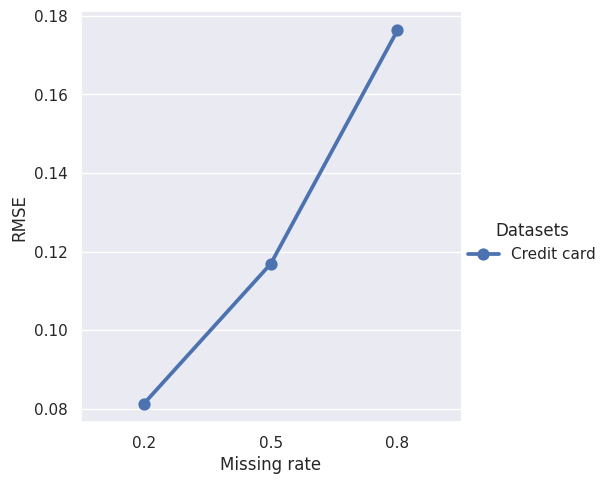

In [ ]:
df = pd.DataFrame(list(zip(missing_rates, total_6[0])),
                  columns =['Missing rate', 'Credit card'])

# df = pd.DataFrame(list(zip(missing_rates, total_6[0])), columns=['Missing rate', 'Credit card'])

df = df.melt('Missing rate', var_name='Datasets', value_name='RMSE')
# g = sns.catplot(x='Missing rate %', y="RMSE", hue='Datasets', data=df, kind='point')
sns.catplot(x='Missing rate', y="RMSE", hue='Datasets', data=df, kind='point').savefig("plots/gain/missing.png")

## 7. Prediction Performance, metric: AUROC

In [ ]:
import pandas as pd
df11 = pd.DataFrame(normalisedX)
df11.columns = new_labels
y3 = defaulters['def_pay']
df3 = pd.concat([df11, y3], axis = 1)
df3.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
0,0.969135,0.000097,0.000097,0.000048,0.001163,0.000097,0.000097,-0.000048,-0.000048,-0.000097,...,0.000000,0.000000,0.000000,0.000000,0.033387,0.000000,0.000000,0.000000,0.000000,1
1,0.998005,0.000017,0.000017,0.000017,0.000216,-0.000008,0.000017,0.000000,0.000000,0.000000,...,0.027212,0.028734,0.027121,0.000000,0.008317,0.008317,0.008317,0.000000,0.016633,1
2,0.898265,0.000020,0.000020,0.000020,0.000339,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.143034,0.149192,0.155190,0.015151,0.014971,0.009981,0.009981,0.009981,0.049904,0
3,0.456620,0.000018,0.000018,0.000009,0.000338,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.258575,0.264465,0.269835,0.018265,0.018438,0.010959,0.010046,0.009763,0.009132,0
4,0.615783,0.000012,0.000025,0.000012,0.000702,-0.000012,0.000000,-0.000012,0.000000,0.000000,...,0.257890,0.235795,0.235611,0.024631,0.451750,0.123157,0.110841,0.008485,0.008362,0


In [ ]:
### df3 는 ID 가 삭제되고 y target 이 결합된 dataset ###
df3.to_csv('creditwlabel5.csv', index=False)
#DC dataset
dcdata = pd.read_csv('creditwlabel5.csv')

In [ ]:
dcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  float64
 2   EDUCATION  30000 non-null  float64
 3   MARRIAGE   30000 non-null  float64
 4   AGE        30000 non-null  float64
 5   PAY_1      30000 non-null  float64
 6   PAY_2      30000 non-null  float64
 7   PAY_3      30000 non-null  float64
 8   PAY_4      30000 non-null  float64
 9   PAY_5      30000 non-null  float64
 10  PAY_6      30000 non-null  float64
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [ ]:
### 5-fold cross validation 으로 hyp-params tuning 후 logistic regression 으로 prediction ###

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 데이터 불러오기
data = pd.read_csv('creditwlabel5.csv')
X = data.drop(columns=['def_pay'])
y = data['def_pay']

# 개선된 파이프라인: SMOTE -> 스케일링 -> 변수 선택 -> 로지스틱 회귀
pipeline = imbPipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# 세밀한 하이퍼파라미터 그리드
param_grid = [
    {
        'feature_selection__k': [5, 10, 15, 'all'],
        'classifier__C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'feature_selection__k': [5, 10, 15, 'all'],
        'classifier__C': [0.001,  0.01, 0.1, 0.5, 1, 5, 10, 50],
        'classifier__penalty': ['l1'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'feature_selection__k': [5, 10, 15, 'all'],
        'classifier__C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50],
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__l1_ratio': [0.2, 0.5, 0.8],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'feature_selection__k': [5, 10, 15, 'all'],
        'classifier__penalty': ['none'],
        'classifier__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'classifier__class_weight': [None, 'balanced']
    }
]

# 교차검증: 5-fold stratified
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# 모델 학습
grid_search.fit(X, y)

# 결과 출력
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)


Fitting 5 folds for each of 672 candidates, totalling 3360 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
160 fits failed out of a total of 3360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt,

Best Parameters: {'classifier__C': 0.01, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg', 'feature_selection__k': 'all'}
Best ROC AUC Score: 0.7214963099842391
